In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

# https://www.kaggle.com/competitions/practical-ml-chocolate/data
# https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings/

# https://www.c-spot.com/

# Get data

In [2]:
df_train = pd.read_csv('chocolate_train.csv')
df_test = pd.read_csv('chocolate_test_new.csv')
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [3]:
print(f'Train data has {df_train.shape[1]} columns and {df_train.shape[0]} rows')
print(f'Train data has {df_test.shape[1]} columns and {df_test.shape[0]} rows')

Train data has 9 columns and 1255 rows
Train data has 8 columns and 540 rows


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [5]:
# Make percentage float
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].apply(lambda x: float(x.strip('%')))
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: float(x.strip('%')))

In [6]:
df_train.describe()

,REF,Review,Cocoa Percent,Rating
count,1255.000000,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,71.790438,3.176494
std,551.284249,2.922499,6.397448,0.478948
min,5.000000,2006.000000,46.000000,1.000000
25%,593.000000,2010.000000,70.000000,2.750000
50%,1077.000000,2013.000000,70.000000,3.250000
75%,1514.000000,2015.000000,75.000000,3.500000
max,1952.000000,2017.000000,100.000000,5.000000


## Fill NaNs and empty cells

In [7]:
df_train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

In [8]:
df_train = df_train.applymap(lambda x: np.nan if str(x).strip()=="\xa0" else x)
df_train = df_train.applymap(lambda x: np.nan if str(x).strip()=="" else x)

df_test = df_test.applymap(lambda x: np.nan if str(x).strip()=="\xa0" else x)
df_test = df_test.applymap(lambda x: np.nan if str(x).strip()=="" else x)

In [9]:
df_train.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [10]:
mode_bean_type = df_train['Bean Type'].mode()[0]
mode_broad_bean_origin = df_train['Broad Bean Origin'].mode()[0]

In [11]:
df_train['Broad Bean Origin'] = df_train['Broad Bean Origin'].fillna('Mixed')
df_test['Broad Bean Origin'] = df_test['Broad Bean Origin'].fillna('Mixed')

df_train['Bean Type'] = df_train['Bean Type'].fillna('Unknown')
df_test['Bean Type'] = df_test['Bean Type'].fillna('Unknown')

### Misspellings

In [12]:
df_train.replace(
    {
        'Eucador': 'Ecuador',
        'Domincan Republic': 'Dominican Republic',
        'Niacragua': 'Nicaragua'
    },
    inplace=True)

df_test.replace(
    {
        'Eucador': 'Ecuador',
        'Domincan Republic': 'Dominican Republic',
        'Niacragua': 'Nicaragua'
    },
    inplace=True)

## Chocolate price

In [13]:
pd.concat([df_train['Company'], df_test['Company']])

0                    Willie's Cacao
1                Beschle (Felchlin)
2                       Dark Forest
3      Brasstown aka It's Chocolate
4                            Pralus
                   ...             
535                 Monsieur Truffe
536                   Cacao Hunters
537                          Bonnat
538           Altus aka Cao Artisan
539                      Holy Cacao
Name: Company, Length: 1795, dtype: object

In [14]:
df_train[df_train['Company'] == 'Altus aka Cao Artisan']

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
203,Altus aka Cao Artisan,Peru,1133,2013,60.0,U.S.A.,3.25,Unknown,Peru
394,Altus aka Cao Artisan,Bolivia,1129,2013,80.0,U.S.A.,3.25,Unknown,Bolivia
395,Altus aka Cao Artisan,Villa Andina,1732,2016,60.0,U.S.A.,2.50,Unknown,Peru
577,Altus aka Cao Artisan,Conacado,1125,2013,60.0,U.S.A.,3.00,Trinitario,Dominican Republic
628,Altus aka Cao Artisan,Gruppo Salinas,1732,2016,60.0,U.S.A.,2.75,Unknown,Ecuador
665,Altus aka Cao Artisan,Momotombo,1728,2016,60.0,U.S.A.,2.75,Unknown,Nicaragua
1188,Altus aka Cao Artisan,Sur del Lago,1125,2013,60.0,U.S.A.,2.50,Unknown,Venezuela
1189,Altus aka Cao Artisan,Bolivia,1133,2013,60.0,U.S.A.,3.00,Unknown,Bolivia


In [15]:
price_100g = {'Soma': 18.5, 'Bonnat': 20.5, 'A. Morin': 12.0, 'Fresco': 18.0, 'Pralus': 10.15,
            'Arete': 16.9, 'Valrhona': 8.3, 'Hotel Chocolat': 8.2, 'Hotel Chocolat (Coppeneur)': 10.9,
            'Artisan du Chocolat': 10.5, 'Rogue': 33.3, 'Domori': 14.0, 'Guittard': 6.4,
            'Coppeneur': 11.1, 'Mast Brothers': 10.0, 'Scharffen Berger': 7.1, 'Zotter': 6.5,
            'Smooth Chocolator, The': 20.8, 'Dandelion': 23.2, 'Szanto Tibor': 11.0,
            'Castronovo': 22.6, 'Tejas': np.nan, 'Pierre Marcolini': 20.0, 'Bittersweet Origins': np.nan,
            'Dick Taylor': 17.9, 'Amedei': 13.1, 'Pacari': 9.6, "Duffy's": 12.3,
            'Friis Holm (Bonnat)': 11.1, 'Friis Holm': 11.1, 'Madre': 29.7, 'Middlebury': np.nan,
            'Sirene': 12.9, 'Palette de Bine': 22.0, 'French Broad': 16.6, 'Marou': 11.8,
            'Idilio (Felchlin)': 13.5, 'Map Chocolate': 28.0, 'La Maison du Chocolat (Valrhona)': 11.9,
            'Michel Cluizel': 18.6, 'Altus aka Cao Artisan': np.nan, 'Letterpress': 25.0,
            'Fruition': 25.0, 'Ritual': 20.0, "Brasstown aka It's Chocolate": 13.3,
            'Cacao Sampaka': 5.2, 'Holy Cacao': 14.4}

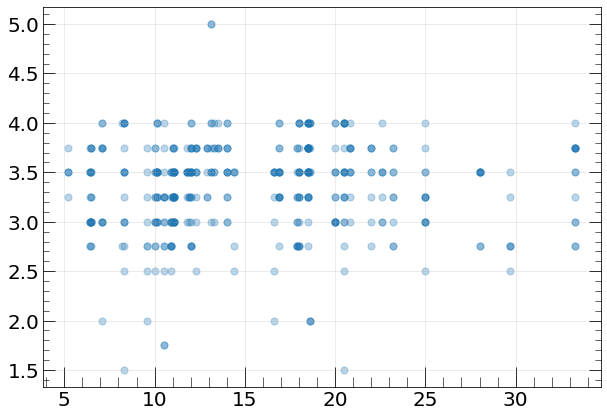

In [16]:
df_train['Price'] = df_train['Company'].apply(lambda x: price_100g.get(x, np.nan))
df_test['Price'] = df_test['Company'].apply(lambda x: price_100g.get(x, np.nan))

plt.scatter(df_train['Price'], df_train['Rating'], alpha=0.3, s=50)

In [17]:
df_train['Price'] = df_train['Price'].fillna(df_train['Price'].median())
df_test['Price'] = df_test['Price'].fillna(df_test['Price'].median())

In [18]:
df_train[['Price', 'Rating']].corr()

,Price,Rating
Price,1.000000,0.096665
Rating,0.096665,1.000000


# EDA

In [19]:
df_train.groupby('Bean Type').agg(MeanRating=('Rating', 'mean'), Count=('Bean Type', 'count'))\
    .sort_values(by='Count', ascending=False)[:10]

,MeanRating,Count
Bean Type,,
Unknown,3.130366,629
Trinitario,3.255263,285
Criollo,3.185096,104
Forastero,3.127358,53
Forastero (Nacional),3.191176,34
"Criollo, Trinitario",3.257812,32
Forastero (Arriba),2.773438,32
Blend,3.437500,28
Criollo (Porcelana),3.361111,9


In [20]:
print('List of features:', '-'*25, sep='\n')
for i in df_train.drop('Rating', axis=1).columns:
    print(i)

List of features:
-------------------------
Company
Specific Bean Origin
REF
Review
Cocoa Percent
Company Location
Bean Type
Broad Bean Origin
Price


In [21]:
train_target = df_train['Rating']
df_train.drop(['Rating'], axis=1, inplace=True)
df_train['Rating'] = train_target

## Correlation matrix (numeric features)

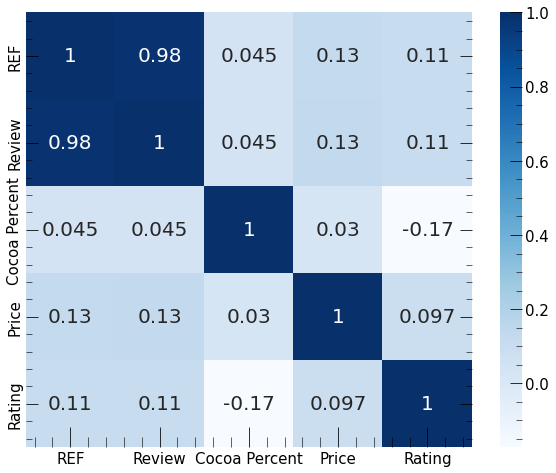

In [22]:
plt.figure(figsize = (10,8))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

## Correlation matrix (categorical features)

In [23]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999638,0.616841,0.603562
Specific Bean Origin,0.771074,1.000000,0.811367,0.907956,0.985204
Company Location,0.999638,0.811367,1.000000,0.241511,0.389432
Bean Type,0.616841,0.907956,0.241511,1.000000,0.388054
Broad Bean Origin,0.603562,0.985204,0.389432,0.388054,1.000000


Correlated features (may drop one from each pair):
* REF and Review
* Company and Company Location
* Broad Bean Origin and Specific Bean Origin
* Specific Bean Origin and Bean Type

From every pair of highly correlated categorical features we should drop the one with maximum unique values to avoid overfitting

## Outliers

In [24]:
cat_cols = df_train.columns[df_train.dtypes == 'object']
num_cols = df_train.columns[df_train.dtypes != 'object']

Train data
REF


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


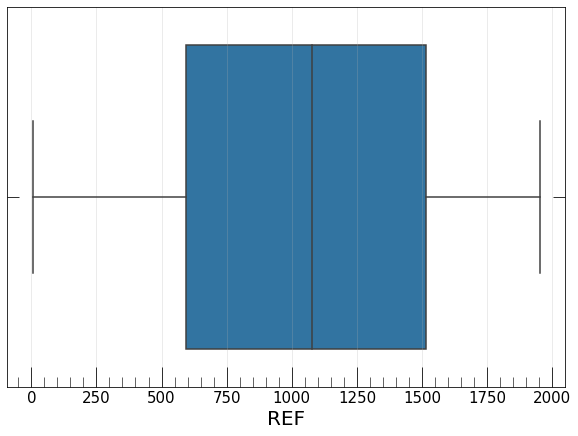

Review


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


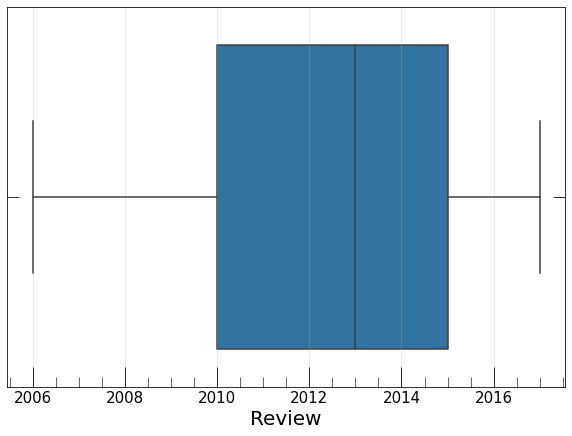

Cocoa Percent


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


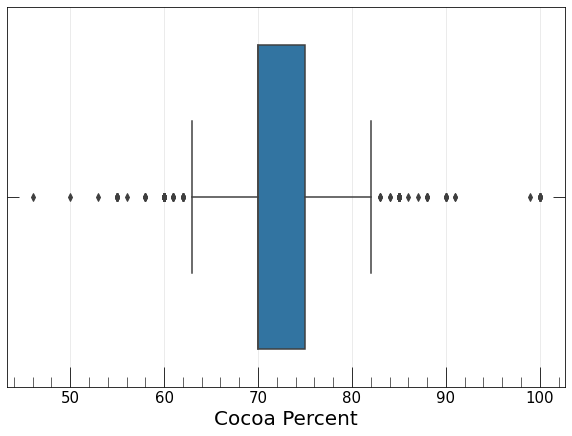

Price


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


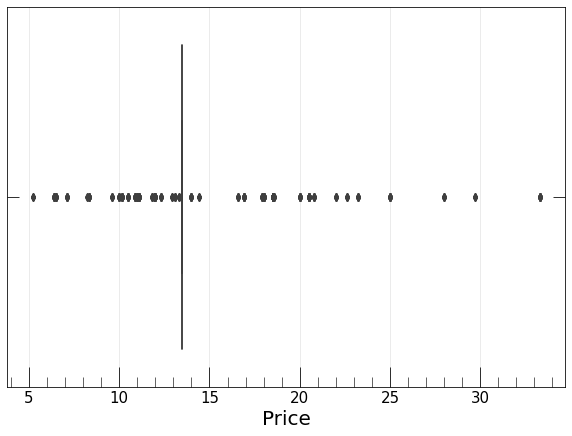

Rating


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


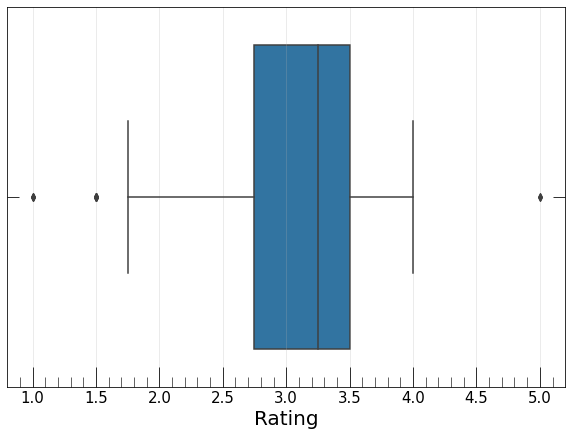

In [25]:
print('Train data')
for col in num_cols:
    print(col)
    sns.boxplot(df_train[col])
    plt.show()

Test data
REF


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


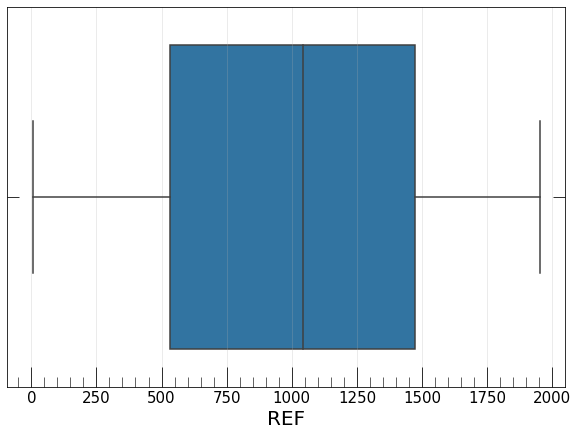

Review


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


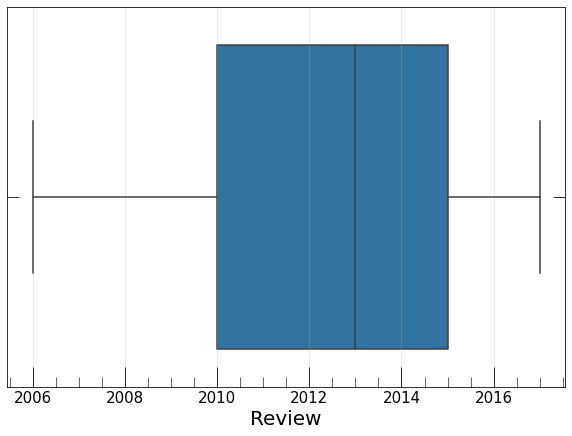

Cocoa Percent


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


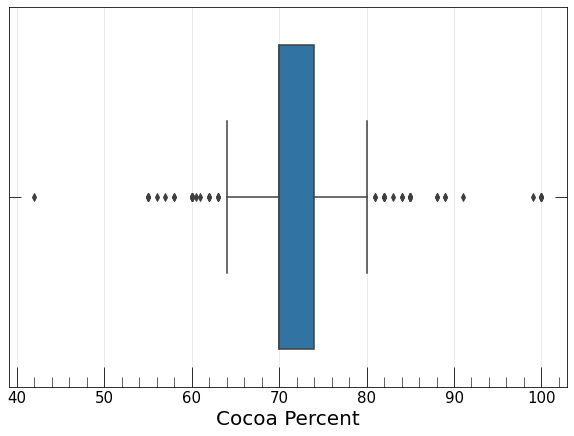

Price


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


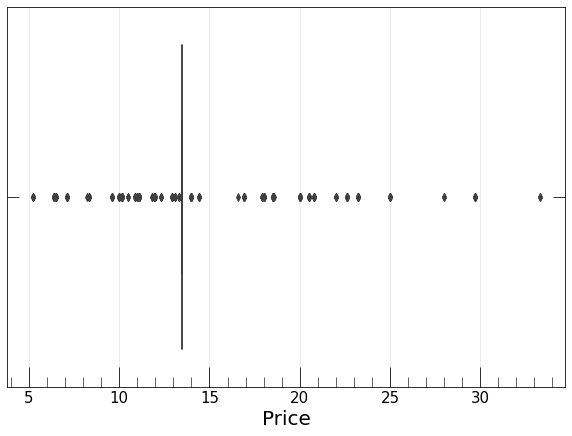

In [26]:
print('Test data')
for col in num_cols:
    if col != 'Rating':
        print(col)
        sns.boxplot(df_test[col])
        plt.show()

In [27]:
outliers_cocoa_percent = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_train = df_train.drop(outliers_cocoa_percent.index, axis=0)

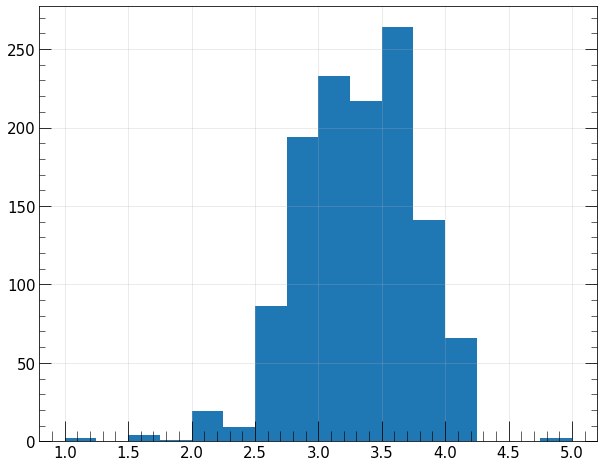

In [28]:
plt.figure(figsize=(10, 8))
plt.hist(df_train['Rating'], bins=16)
plt.show()

In [29]:
outliers_rating = df_train[(df_train['Rating'] == 5.0) | (df_train['Rating'] <= 1.5)]
df_train = df_train.drop(outliers_rating.index, axis=0)

In [30]:
train_target = df_train['Rating']

# Baseline model (ansamble)

In [31]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
import optuna

In [33]:
from sklearn.pipeline import Pipeline

p_baseline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_cols)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_jobs=-1))
])

p_baseline.fit(X_train, y_train)
pred = p_baseline.predict(X_val)
r2_score(y_val, pred)

0.039224370927528396

# CatBoost

In [34]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 1, 5, 6, 7])

In [35]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.14693947904503424

In [36]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,19.689271
7,Broad Bean Origin,16.403773
6,Bean Type,13.597161
5,Company Location,12.414143
4,Cocoa Percent,11.887427
2,REF,10.797810
8,Price,6.048576
1,Specific Bean Origin,4.997811
3,Review,4.164027


# Feature engineering

Some ideas I already tried:
* Broad company location (Africa, Caribbean, etc)
* Broader cocoa bean origin (Africa, Caribbean, etc)
* Best Companies (from internet sources)
* Top cocoa bean production countries (amount and quality)

More to try:
* Company location matches broad bean origin
* Analyze text of some features: Specific Bean Origin and Company

### Matched Regions

In [37]:
df_train[['Company Location', 'Broad Bean Origin']].head()

,Company Location,Broad Bean Origin
0,U.K.,Venezuela
1,Switzerland,Venezuela
2,U.S.A.,Tanzania
3,U.S.A.,Dominican Republic
4,France,Indonesia


In [38]:
df_train['Matched Regions'] = np.where(df_train['Company Location'] == df_train['Broad Bean Origin'], 1, 0)
df_test['Matched Regions'] = np.where(df_test['Company Location'] == df_test['Broad Bean Origin'], 1, 0)

In [39]:
df_train.groupby('Matched Regions').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'))

,MeanRating,StdRating
Matched Regions,,
0,3.204713,0.44118
1,3.121622,0.42206


### Broad Locations (parts of the world)

In [40]:
broad_locations = {'Europe': ['U.K.', 'Switzerland', 'France', 'Belgium', 'Spain', 'Italy',
                              'Austria', 'Sweden', 'Ireland', 'Poland', 'Hungary', 'Germany',
                              'Denmark', 'Lithuania', 'Scotland', 'Finland', 'Iceland',
                              'Amsterdam', 'Wales', 'Netherlands', 'Portugal', 'Czech Republic'],
                   'North America': ['U.S.A.', 'Canada'],
                   'Africa': ['Madagascar', 'South Africa', 'Ghana', 'Sao Tome', 'Tanzania',
                              'Indonesia', 'Congo', 'Liberia', 'Principe', 'Sao Tome & Principe',
                              'Gabon', 'Ivory Coast', 'Uganda', 'Nigeria', 'West Africa'],
                   'Caribbean': ['Colombia', 'Venezuela', 'Honduras', 'Guatemala',
                                 'Domincan Republic', 'Grenada', 'Puerto Rico', 'Costa Rica',
                                 'St. Lucia', 'Nicaragua', 'Martinique', 'Niacragua', 'Cost Rica, Ven',
                                 'Trinidad', 'Panama', 'Jamaica', 'Haiti', 'Cuba', 'Venezuela, Ghana',
                                 'Ven.,Ecu.,Peru,Nic.', 'Tobago', 'Carribean(DR/Jam/Tri)',
                                 'Venezuela, Java', 'Ven, Bolivia, D.R.', 'Venezuela, Carribean',
                                 'Dominican Republic', 'Carribean'],
                   'Asia & Oceania': ['Japan', 'Vietnam', 'Philippines', 'Fiji', 'Australia',
                                      'South Korea', 'Israel', 'Singapore', 'India', 'Russia',
                                      'New Zealand', 'Papua New Guinea', 'Hawaii', 'Solomon Islands',
                                      'Sri Lanka', 'Malaysia', 'Samoa', 'Philippines', 'Togo',
                                      'Vanuatu'],
                   'South America': ['Ecuador', 'Brazil', 'Peru', 'Eucador', 'Argentina',
                                     'Chile', 'Mexico', 'Bolivia', 'Suriname', 'Peru, Dom. Rep',
                                     'Central and S. America', 'Colombia, Ecuador', 'Dom. Rep., Madagascar',
                                     'South America', 'Belize', 'El Salvador'],
                   'Mixed': ['Trinidad, Ecuador', 'South America, Africa', 'PNG, Vanuatu, Mad',
                             'Mad., Java, PNG', 'Peru, Mad., Dom. Rep.', 'Indonesia, Ghana', 'Madagascar & Ecuador',
                             'Venez,Africa,Brasil,Peru,Mex', 'DR, Ecuador, Peru', 'Dominican Rep., Bali',
                             'Peru, Madagascar', 'Venezuela, Dom. Rep.', 'Peru, Ecuador, Venezuela',
                             'Ven., Trinidad, Mad.', 'Ven., Indonesia, Ecuad.', 'Ghana, Domin. Rep',
                             'Peru, Belize', 'Guat., D.R., Peru, Mad., PNG']
                   }

In [41]:
def location_in_list(location, locations_dict=broad_locations):
    for k, v in broad_locations.items():
        if location in v:
            return k
    return 'Other'

In [42]:
df_train['Broad Company Location'] = df_train['Company Location'].apply(lambda x: location_in_list(x))
df_test['Broad Company Location'] = df_test['Company Location'].apply(lambda x: location_in_list(x))

In [43]:
df_train.groupby('Broad Company Location').agg(MeanRating=('Rating', 'mean'),
                                               StdRating=('Rating', 'std'),
                                               Count=('Broad Company Location', 'count'))

,MeanRating,StdRating,Count
Broad Company Location,,,
Africa,3.125000,0.471621,18
Asia & Oceania,3.259615,0.381049,78
Caribbean,3.143443,0.424409,61
Europe,3.238402,0.443727,388
North America,3.175576,0.442901,608
South America,3.116883,0.436011,77


In [44]:
df_train['Bean Origin World'] = df_train['Broad Bean Origin'].apply(lambda x: location_in_list(x))
df_test['Bean Origin World'] = df_test['Broad Bean Origin'].apply(lambda x: location_in_list(x))

In [45]:
df_train.groupby('Bean Origin World').agg(MeanRating=('Rating', 'mean'),
                                          StdRating=('Rating', 'std'),
                                          Count=('Bean Origin World', 'count'))

,MeanRating,StdRating,Count
Bean Origin World,,,
Africa,3.213010,0.449611,196
Asia & Oceania,3.260526,0.360842,95
Caribbean,3.194386,0.440101,472
Mixed,3.342105,0.426635,19
Other,3.098958,0.451768,48
South America,3.175000,0.448473,400


### Best Production

In [46]:
df_train['Rating'].mean()

3.1947154471544716

In [47]:
# Countries producing the best chocolate (according to internet)
best_production_countries = ['Belgium', 'Switzerland', 'Italy', 'Germany', 'Austria', 'Poland',
                             'Ecuador', 'Japan', 'New Zealand', 'Sweden', 'Spain', 'Mexico', 'Brazil',
                             'India', 'Peru', 'Australia', 'U.K.',
                             'Indonesia', 'Tahiland', 'Philippines', 'Ivory Coast', 'U.S.A.']

In [48]:
df_train['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))
df_test['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))

In [49]:
df_train.groupby('Best Production').agg(MeanRating=('Rating', 'mean'),
                                        StdRating=('Rating', 'std'),
                                        Count=('Best Production', 'count'))

,MeanRating,StdRating,Count
Best Production,,,
0,3.27135,0.439808,363
1,3.16263,0.435763,867


### Best Bean Type

In [50]:
best_beans_list = ['Criollo', 'Trinitario'] 
df_train['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))
df_test['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))

In [51]:
df_train.groupby('Best Bean Type').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'),
                                       Count=('Best Bean Type', 'count'))

,MeanRating,StdRating,Count
Best Bean Type,,,
0,3.165493,0.448177,781
1,3.245546,0.419904,449


In [52]:
#df_train.drop('Best Bean Type', axis=1, inplace=True)
#df_test.drop('Best Bean Type', axis=1, inplace=True)

### Multiple Bean Origins

In [53]:
def multiple_names(string):
    answer = 0
    for i  in [',', '&']:
        if i in string:
            answer = 1
    return answer

df_train['Multiple Broad Bean Origins'] = df_train['Broad Bean Origin'].apply(lambda x: multiple_names(x))
df_test['Multiple Broad Bean Origins'] = df_test['Broad Bean Origin'].apply(lambda x: multiple_names(x))

In [54]:
df_train.groupby('Multiple Broad Bean Origins').agg(
    MeanRating=('Rating', 'mean'),
    StdRating=('Rating', 'std'),
    Count=('Multiple Broad Bean Origins', 'count'))

,MeanRating,StdRating,Count
Multiple Broad Bean Origins,,,
0,3.188596,0.437801,1197
1,3.416667,0.453574,33


### Some features from Specific Bean Origin

In [55]:
df_train['SBO Complexity'] = df_train['Specific Bean Origin'].apply(lambda x: x.count(' '))
df_test['SBO Complexity'] = df_test['Specific Bean Origin'].apply(lambda x: x.count(' '))

In [56]:
df_train.groupby('SBO Complexity').agg({'Rating': 'mean', 'SBO Complexity': 'count'})

,Rating,SBO Complexity
SBO Complexity,,
0,3.136273,499
1,3.201563,320
2,3.214286,175
3,3.213362,116
4,3.313380,71
5,3.387097,31
6,3.576923,13
7,3.600000,5


In [57]:
def length_bin(s: str, min_val=0, max_val=50, step=10) -> int:
    n = len(s)
    bins = np.arange(min_val, max_val+step, step)
    for i in range(bins.shape[0]):
        if n > bins[i] and n <= bins[i+1]:
            return i
    

df_train['SBO Length'] = df_train['Specific Bean Origin'].apply(lambda x: length_bin(x))
df_test['SBO Length'] = df_test['Specific Bean Origin'].apply(lambda x: length_bin(x))

In [58]:
df_train.groupby('SBO Length').agg({'Rating': 'mean', 'SBO Length': 'count'})

,Rating,SBO Length
SBO Length,,
0,3.152284,591
1,3.183379,364
2,3.270000,175
3,3.341176,85
4,3.433333,15


Again there is some trend

In [59]:
import string
def complexity_plus(s):
    n = 0
    symbols = string.punctuation + ' '
    for i in symbols:
        n += s.count(i)
    return n

df_train['SBO Complexity plus'] = df_train['Specific Bean Origin'].apply(lambda x: complexity_plus(x))
df_test['SBO Complexity plus'] = df_test['Specific Bean Origin'].apply(lambda x: complexity_plus(x))

In [60]:
df_train.groupby('SBO Complexity plus').agg({'Rating': 'mean', 'SBO Complexity plus': 'count'})

,Rating,SBO Complexity plus
SBO Complexity plus,,
0,3.142495,493
1,3.167969,256
2,3.214286,105
3,3.269397,116
4,3.145570,79
5,3.290909,55
6,3.228571,35
7,3.272059,34
8,3.440000,25


In [61]:
def upper_case(s):
    n = 0
    for i in string.ascii_uppercase:
        n += s.count(i)
    return n

df_train['SBO Upper'] = df_train['Specific Bean Origin'].apply(lambda x: upper_case(x))
df_test['SBO Upper'] = df_test['Specific Bean Origin'].apply(lambda x: upper_case(x))

In [62]:
df_train.groupby('SBO Upper').agg({'Rating': 'mean', 'SBO Upper': 'count'})

,Rating,SBO Upper
SBO Upper,,
0,3.083333,3
1,3.137024,551
2,3.200549,364
3,3.238176,148
4,3.272727,77
5,3.350000,55
6,3.434783,23
7,3.400000,5
8,3.750000,2


### Same for Company

In [63]:
df_train['Company Complexity plus'] = df_train['Company'].apply(lambda x: complexity_plus(x))
df_test['Company Complexity plus'] = df_test['Company'].apply(lambda x: complexity_plus(x))

In [64]:
df_train.groupby('Company Complexity plus').agg({'Rating': 'mean'})

,Rating
Company Complexity plus,
0,3.224884
1,3.170455
2,3.185000
3,3.188953
4,3.068182
5,3.040000
6,3.305556
7,2.750000


In [65]:
df_train['Company Length'] = df_train['Company'].apply(lambda x: length_bin(x, 0, 40, 5))
df_test['Company Length'] = df_test['Company'].apply(lambda x: length_bin(x, 0, 40, 5))

In [66]:
df_train.groupby('Company Length').agg({'Rating': 'mean'})

,Rating
Company Length,
0,3.217105
1,3.218557
2,3.186966
3,3.186170
4,3.079114
5,3.065476
6,3.208333
7,3.416667


In [67]:
df_train['Company Complexity'] = df_train['Company'].apply(lambda x: x.count(' '))
df_test['Company Complexity'] = df_test['Company'].apply(lambda x: x.count(' '))

In [68]:
df_train.groupby('Company Complexity').agg({'Rating': 'mean'})

,Rating
Company Complexity,
0,3.224189
1,3.172566
2,3.138199
3,3.103659
4,3.227273


In [69]:
df_train['Company Upper'] = df_train['Company'].apply(lambda x: upper_case(x))
df_test['Company Upper'] = df_test['Company'].apply(lambda x: upper_case(x))

In [70]:
df_train.groupby('Company Upper').agg({'Rating': 'mean'})

,Rating
Company Upper,
0,3.045455
1,3.237269
2,3.169666
3,3.108929
4,3.144737
5,2.666667
6,2.500000


## Feature selection

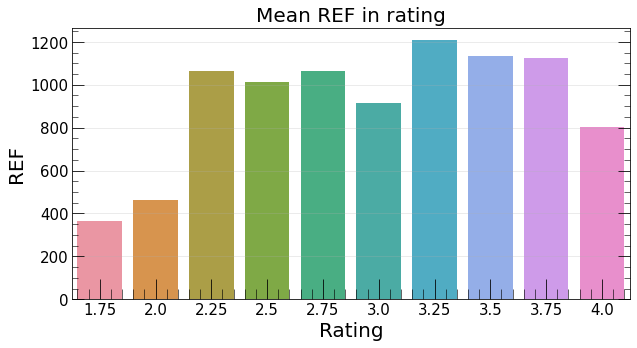

In [71]:
def distribution(data, title, x_label, y_label, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-pastel')
    density = sns.barplot(x=data.index, y=data.values)
    title = plt.title(title, fontdict={'fontsize': 20})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plt.show()

rating_cocoa_percent_dist = df_train.groupby('Rating')['REF'].mean()

distribution(data=rating_cocoa_percent_dist,
             title='Mean REF in rating',
             x_label='Rating',
             y_label='REF')

In [72]:
train_rating = df_train.Rating
df_train.drop('Rating', axis=1, inplace=True)
df_train['Rating'] = train_rating

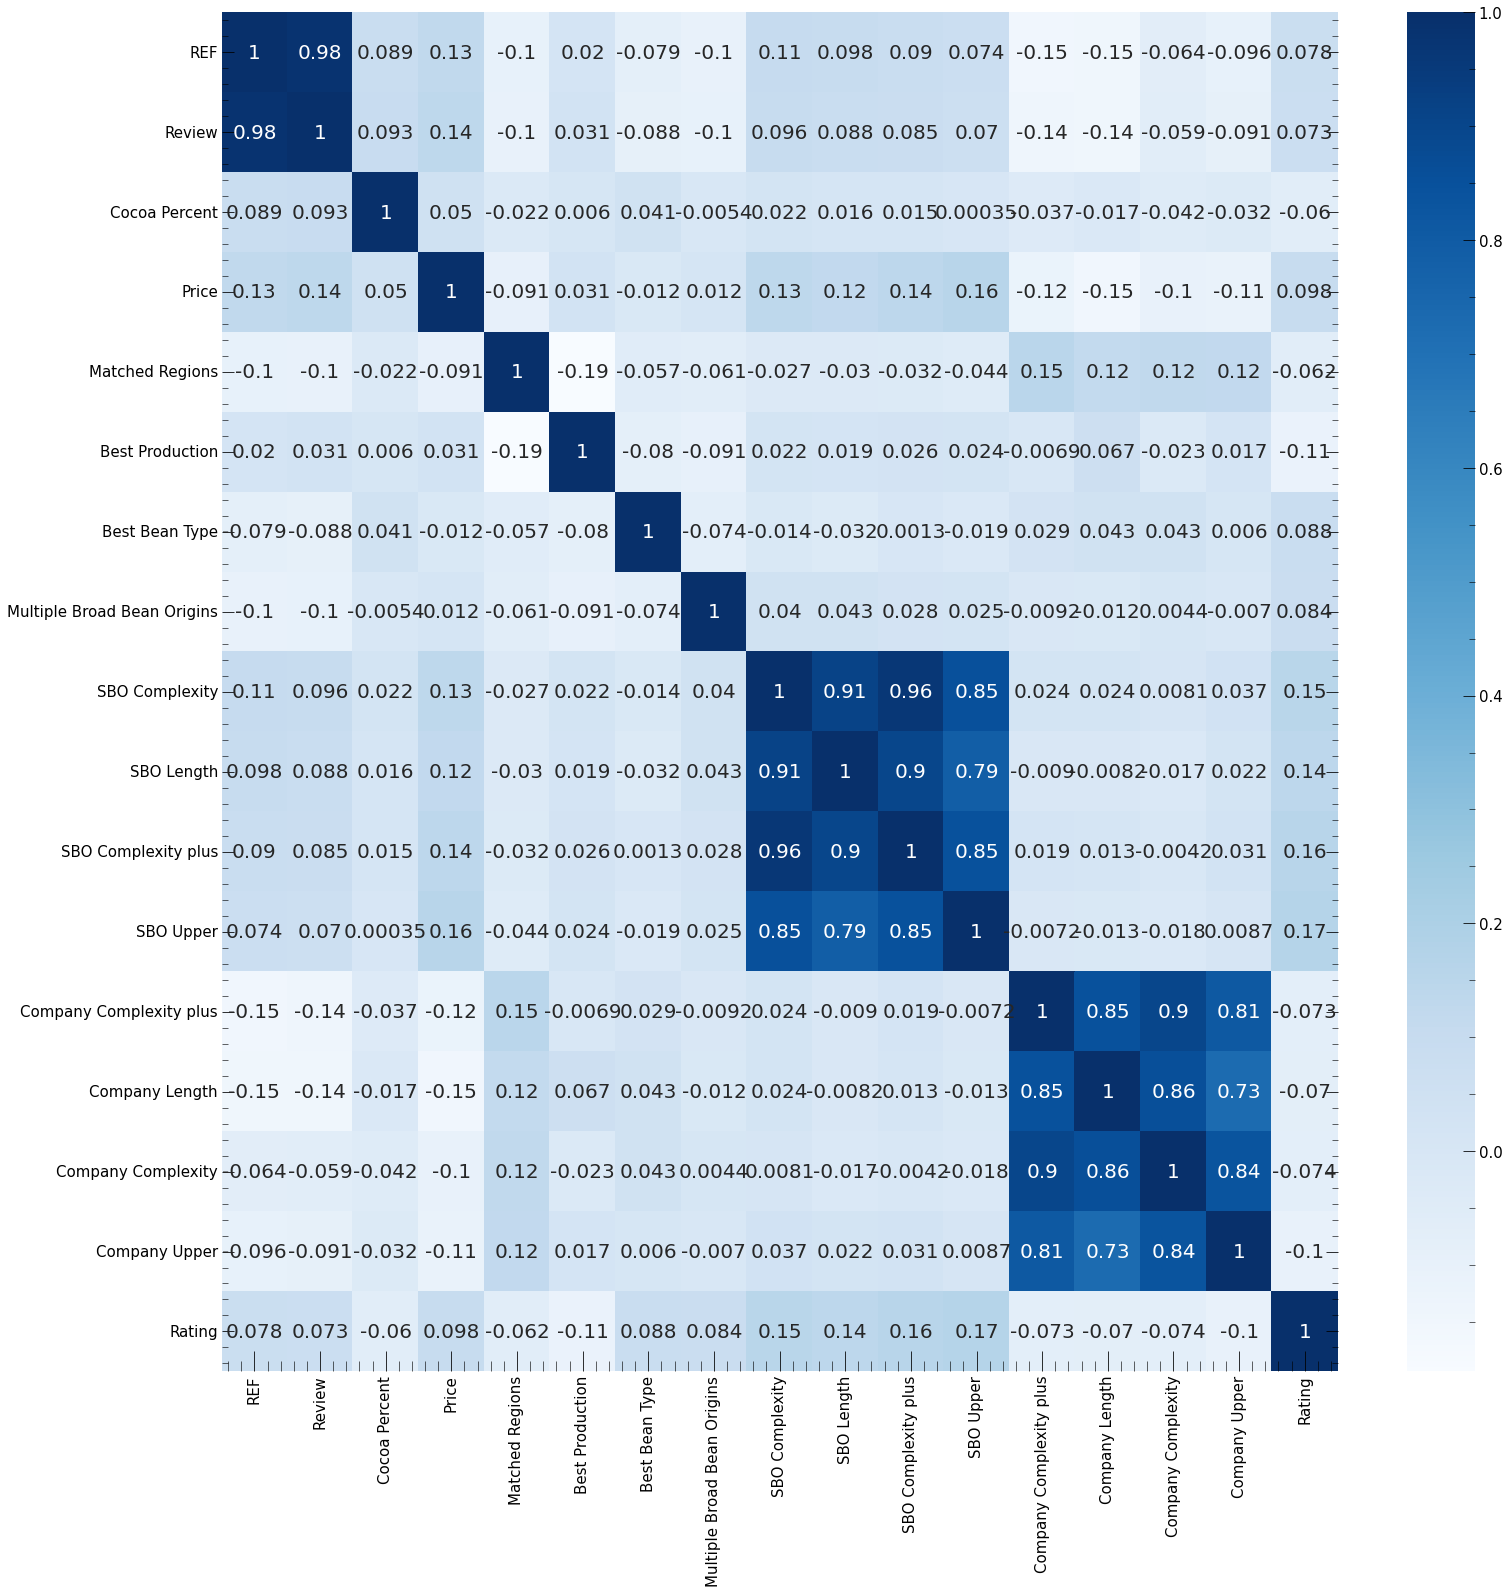

In [73]:
plt.figure(figsize = (25, 25))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

In [74]:
numeric_columns = df_train.columns[(df_train.dtypes == int) | (df_train.dtypes == float)]
new_columns = numeric_columns[[any(j in i for j in ['SBO', 'Company', 'Rating']) for i in numeric_columns]]
new_columns

Index(['SBO Complexity', 'SBO Length', 'SBO Complexity plus', 'SBO Upper',
       'Company Complexity plus', 'Company Length', 'Company Complexity',
       'Company Upper', 'Rating'],
      dtype='object')

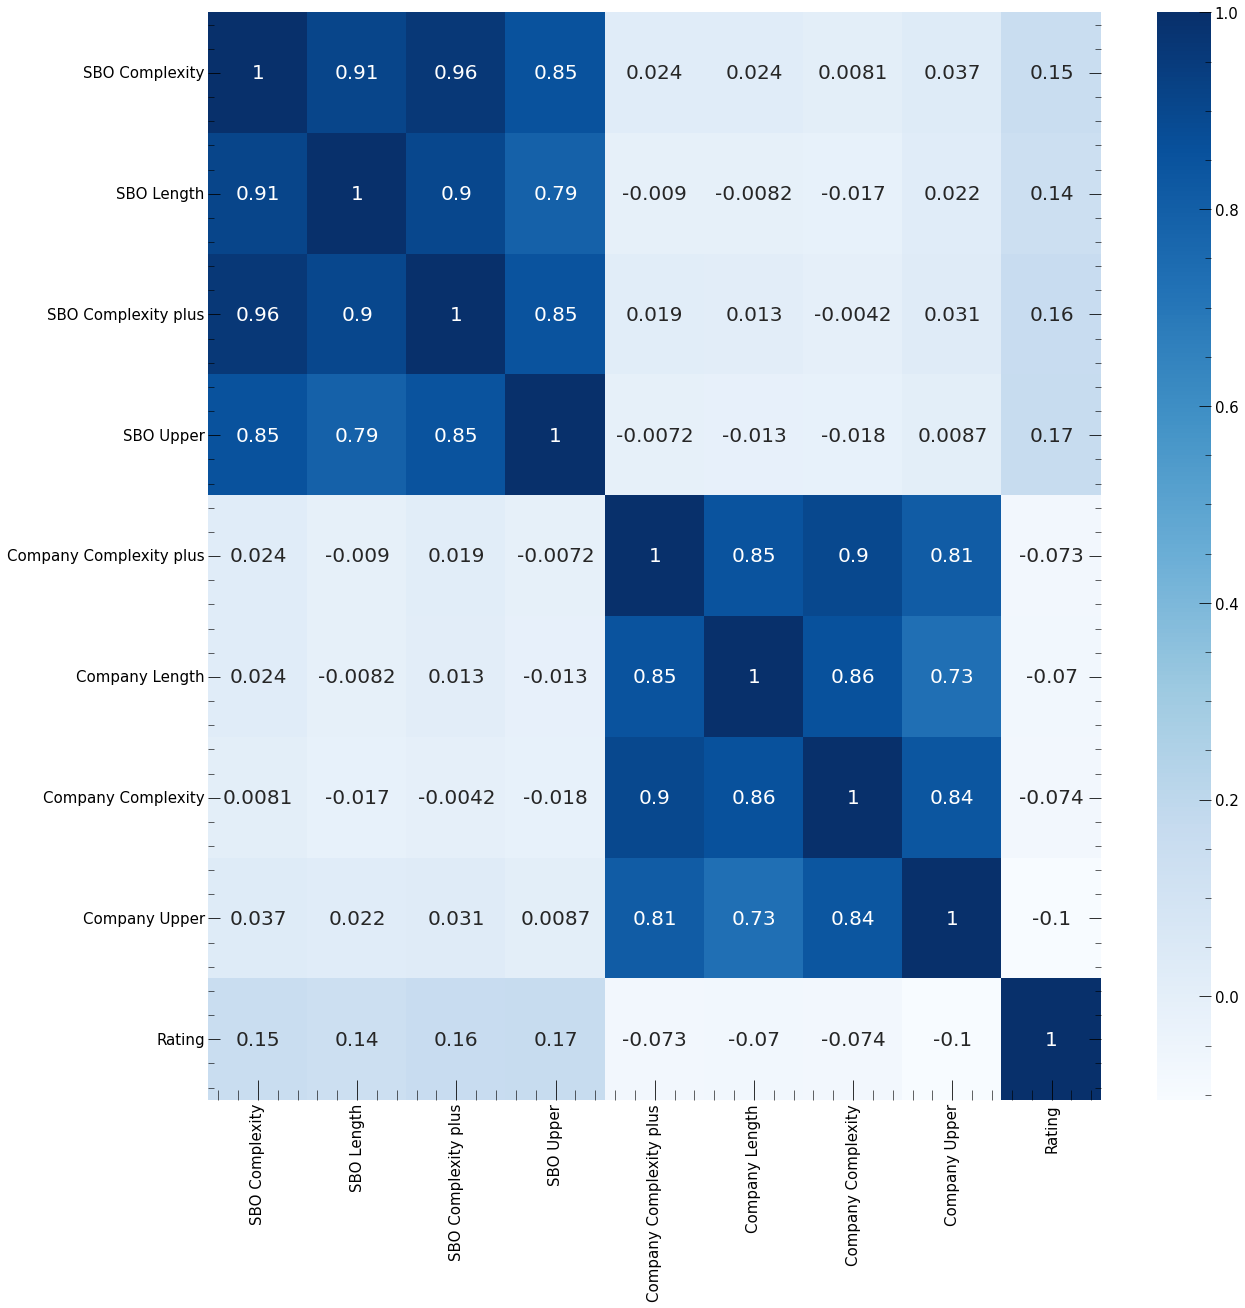

In [75]:
plt.figure(figsize = (20, 20))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train[new_columns].corr(), annot=True, cmap="Blues")

plt.show()

Keep 'SBO Complexity' and 'Company Upper'

In [77]:
for i in range(new_columns.shape[0]):
    print(f'{i} - {new_columns[i]}')

0 - SBO Complexity
1 - SBO Length
2 - SBO Complexity plus
3 - SBO Upper
4 - Company Complexity plus
5 - Company Length
6 - Company Complexity
7 - Company Upper
8 - Rating


In [78]:
cols_to_drop = np.delete(new_columns, [0, 7, 8])
cols_to_drop

Index(['SBO Length', 'SBO Complexity plus', 'SBO Upper',
       'Company Complexity plus', 'Company Length', 'Company Complexity'],
      dtype='object')

In [79]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [80]:
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Price,Matched Regions,Broad Company Location,Bean Origin World,Best Production,Best Bean Type,Multiple Broad Bean Origins,SBO Complexity,Company Upper,Rating
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,Trinitario,Venezuela,13.50,0,Europe,Caribbean,1,1,0,1,2,3.25
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,Unknown,Venezuela,13.50,0,Europe,Caribbean,1,0,0,5,2,3.50
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,Unknown,Tanzania,13.50,0,North America,Africa,1,0,0,0,2,3.00
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,Trinitario,Dominican Republic,13.30,0,North America,Caribbean,1,1,0,0,3,3.00
4,Pralus,"Java, Indonesie",32,2006,75.0,France,Criollo,Indonesia,10.15,0,Europe,Africa,0,1,0,1,1,3.50


## Correlation matrix (categorical features)

In [81]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin,Broad Company Location,Bean Origin World
Company,1.000000,0.771990,0.999638,0.616787,0.602175,0.998263,0.636328
Specific Bean Origin,0.771990,1.000000,0.812310,0.907782,0.988956,0.844054,0.988975
Company Location,0.999638,0.812310,1.000000,0.239082,0.384821,1.000000,0.334642
Bean Type,0.616787,0.907782,0.239082,1.000000,0.387747,0.297409,0.393746
Broad Bean Origin,0.602175,0.988956,0.384821,0.387747,1.000000,0.440322,1.000000
Broad Company Location,0.998263,0.844054,1.000000,0.297409,0.440322,1.000000,0.267637
Bean Origin World,0.636328,0.988975,0.334642,0.393746,1.000000,0.267637,1.000000


In [82]:
df_train = df_train.drop(['Review'], axis=1)
df_test = df_test.drop(['Review'], axis=1)

In [138]:
cols_to_drop = ['Matched Regions', 'Best Production', 'Multiple Broad Bean Origins',
               'Specific Bean Origin', 'Best Bean Type', 'Company Upper',
               'Broad Company Location', 'Price'] # ''Specific Bean Origin''
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

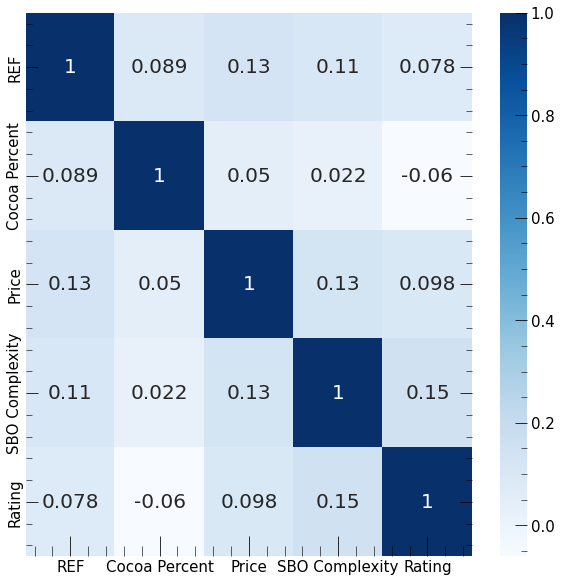

In [122]:
plt.figure(figsize = (10, 10))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

# CatBoost with new features

In [123]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna

In [139]:
X = df_train.drop(['Rating'], axis=1)
y = df_train.Rating

#df_test.drop(['Matched Regions', 'Best Production', 'Specific Bean Origin',
#    'Multiple Broad Bean Origins', 'Best Bean Type', 'Company Upper'], axis=1, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  random_state=42)

In [140]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 3, 4, 5, 6])

In [141]:
model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.15125440952015334

In [142]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,24.562330
4,Bean Type,13.601948
3,Company Location,12.529571
1,REF,12.176137
5,Broad Bean Origin,9.894999
2,Cocoa Percent,9.645231
6,Bean Origin World,9.010697
7,SBO Complexity,8.579088


## CatBoost hyperparameters tuning

In [143]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        #"min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  custom_metric='R2',
                                  verbose=False)

    estimator.fit(X_train,
                  y_train,
                  eval_set=[(X_val, y_val)],)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_trial)

[I 2023-07-17 21:53:20,456] A new study created in memory with name: no-name-7cc228fa-8193-493a-8eda-d4100413f092
[I 2023-07-17 21:53:22,514] Trial 3 finished with value: 0.4259014855105975 and parameters: {'n_estimators': 313, 'max_depth': 5, 'learning_rate': 0.007}. Best is trial 3 with value: 0.4259014855105975.
[I 2023-07-17 21:53:25,183] Trial 4 finished with value: 0.4218520712719051 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.011}. Best is trial 4 with value: 0.4218520712719051.
[I 2023-07-17 21:53:35,171] Trial 5 finished with value: 0.4183830278203444 and parameters: {'n_estimators': 778, 'max_depth': 7, 'learning_rate': 0.1}. Best is trial 5 with value: 0.4183830278203444.
[I 2023-07-17 21:53:35,273] Trial 2 finished with value: 0.41681391965417736 and parameters: {'n_estimators': 884, 'max_depth': 8, 'learning_rate': 0.055}. Best is trial 2 with value: 0.41681391965417736.
[I 2023-07-17 21:53:35,747] Trial 1 finished with value: 0.418954636441490

[I 2023-07-17 21:54:00,830] Trial 39 finished with value: 0.41608909558281343 and parameters: {'n_estimators': 479, 'max_depth': 3, 'learning_rate': 0.049}. Best is trial 36 with value: 0.4153613837815489.
[I 2023-07-17 21:54:01,451] Trial 42 finished with value: 0.4251134737135535 and parameters: {'n_estimators': 255, 'max_depth': 1, 'learning_rate': 0.036000000000000004}. Best is trial 36 with value: 0.4153613837815489.
[I 2023-07-17 21:54:01,455] Trial 43 finished with value: 0.42635816407501764 and parameters: {'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.034}. Best is trial 36 with value: 0.4153613837815489.
[I 2023-07-17 21:54:01,528] Trial 40 finished with value: 0.4186872488953242 and parameters: {'n_estimators': 470, 'max_depth': 5, 'learning_rate': 0.048}. Best is trial 36 with value: 0.4153613837815489.
[I 2023-07-17 21:54:02,889] Trial 45 finished with value: 0.41731174941674165 and parameters: {'n_estimators': 512, 'max_depth': 2, 'learning_rate': 0.054}. Best i

[I 2023-07-17 21:54:39,074] Trial 78 finished with value: 0.4179912880617191 and parameters: {'n_estimators': 846, 'max_depth': 3, 'learning_rate': 0.024}. Best is trial 61 with value: 0.4152917019906265.
[I 2023-07-17 21:54:39,101] Trial 76 finished with value: 0.4169300272864473 and parameters: {'n_estimators': 836, 'max_depth': 5, 'learning_rate': 0.015}. Best is trial 61 with value: 0.4152917019906265.
[I 2023-07-17 21:54:40,795] Trial 83 finished with value: 0.4188248081044684 and parameters: {'n_estimators': 599, 'max_depth': 2, 'learning_rate': 0.047}. Best is trial 61 with value: 0.4152917019906265.
[I 2023-07-17 21:54:43,688] Trial 84 finished with value: 0.41684604320674673 and parameters: {'n_estimators': 654, 'max_depth': 4, 'learning_rate': 0.042}. Best is trial 61 with value: 0.4152917019906265.
[I 2023-07-17 21:54:45,488] Trial 82 finished with value: 0.4214665312008868 and parameters: {'n_estimators': 599, 'max_depth': 7, 'learning_rate': 0.047}. Best is trial 61 with v

FrozenTrial(number=61, state=TrialState.COMPLETE, values=[0.4152917019906265], datetime_start=datetime.datetime(2023, 7, 17, 21, 54, 23, 602033), datetime_complete=datetime.datetime(2023, 7, 17, 21, 54, 25, 842912), params={'n_estimators': 835, 'max_depth': 3, 'learning_rate': 0.053000000000000005}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=0.001)}, trial_id=61, value=None)


In [144]:
print(study.best_trial.params)

{'n_estimators': 835, 'max_depth': 3, 'learning_rate': 0.053000000000000005}


In [145]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

0.1508041736515291

That's better already, let's try it on test

In [146]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,27.643039
1,REF,19.471271
3,Company Location,10.943110
4,Bean Type,10.906100
2,Cocoa Percent,10.511088
5,Broad Bean Origin,8.302661
6,Bean Origin World,6.227257
7,SBO Complexity,5.995472


## Apply tuned CatBoost to test

In [147]:
model.fit(X, y)

In [148]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,28.822257
1,REF,17.223096
2,Cocoa Percent,14.348955
5,Broad Bean Origin,9.853397
3,Company Location,9.424143
4,Bean Type,9.126940
7,SBO Complexity,5.754802
6,Bean Origin World,5.446409


In [149]:
pred_test = model.predict(df_test)
pred_test[:10]

array([3.21594447, 3.14372184, 3.08414134, 3.3081271 , 2.75567062,
       3.02625095, 2.9968919 , 3.11497328, 3.23492341, 2.86089558])

In [150]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v32.csv", index=False)

In [137]:
print(df_train.columns)

Index(['Company', 'REF', 'Cocoa Percent', 'Company Location', 'Bean Type',
       'Broad Bean Origin', 'Price', 'Bean Origin World', 'SBO Complexity',
       'Rating'],
      dtype='object')


In [ ]:
print(study.best_trial.params)

With above features and hyperparameters I managed to get r2 = 0.19519